In [1]:
import sys
import os
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.layers import Dense, Layer, Dropout

print("Successfully imported libraries!")

Successfully imported libraries!


In [2]:
# List available GPUs
gpus = tf.config.list_physical_devices('GPU')
print("GPUs Available:", gpus)

# Check if TensorFlow will place operations on the GPU
print("TensorFlow Version:", tf.__version__)

# Run a quick test
with tf.device('/GPU:0'):
    a = tf.random.normal([1000, 1000])
    b = tf.random.normal([1000, 1000])
    c = tf.matmul(a, b)
    print("Test computation done on GPU")

GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow Version: 2.16.1
Test computation done on GPU


2025-08-10 23:33:13.317218: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-10 23:33:13.368159: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-10 23:33:13.368344: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-10 23:33:13.371451: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:00:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-10 23:33:13.371626: I external/local_xla/xla/stream_executor

In [3]:
# Get the absolute path of the current script's directory
current_dir = os.path.dirname(os.path.abspath("transformer0.ipynb"))

# Get the absolute path of the parent directory (project_folder)
parent_dir = os.path.dirname(current_dir)

# Add the parent directory to the Python path
sys.path.append(parent_dir)

# Now you can import from GetXY.py
from GetXY import x_train, y_train, x_val, y_val, early_stopping

# ... rest of your code
print("Successfully imported variables!")

3 + 3 + -2
2543
4.0

Expressions not in x:
-3 + -3 + 2
True
1457
-4.0
15
-4.0
[-5.   1.   1.   0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5]
Successfully imported variables!


In [4]:
#add a cls token at the beginning of x_train and x_val
pad_value = 15
x_train = np.pad(x_train, ((0, 0), (1, 0)), 'constant', constant_values=pad_value)
x_val = np.pad(x_val, ((0, 0), (1, 0)), 'constant', constant_values=pad_value)

In [5]:
#defining the positional encoder modelled after the formula in the paper that was cited. (generated by gemini)
def posEncoding(max_seq_len, d_model):
    # Create a matrix of angles according to the formula
    angle_rads = get_angles(np.arange(max_seq_len)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
    
    # Apply sine to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    
    # Apply cosine to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    # Add a batch dimension
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

In [6]:
#defining the point-wise FNN
d_ff = 2048 #(original transformer size)
def point_wise_fnn(d_model, d_ff):
    return tf.keras.Sequential([
        Dense(d_ff, activation = "relu"),
        Dense(d_model)
    ])

In [7]:
#scaled dot-product attention
class MH_Attention(Layer):
    def __init__(self, d_model, num_heads):
        super().__init__()
        #for the split_heads function:
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads

        #for the call function:
        #This allows the model to learn the best way to project the input embeddings. (linear projection)
        self.wq = Dense(d_model)
        self.wk = Dense(d_model)
        self.wv = Dense(d_model)

        #it's important to initialize this aswell as the ones above here, so that the model saves the previous weights and is able to learn.
        self.finalDense = Dense(d_model)
        
    def SDP_Attention(self, q, k, v, mask):
        matmul_qk = tf.matmul(q, k, transpose_b=True) #calculate the dotproduct, between the query and a transposed key.
        d_k = tf.shape(k)[-1] #read the dimensionality of the key tensor (here d_model/num_heads = depth)
        d_k = tf.cast(d_k, tf.float32) #convert to float type
        scaled_qk = matmul_qk / tf.math.sqrt(d_k) #scale for purposes discussed in their paper.        

        if mask is not None:
            scaled_qk += (mask * -1e9) #masking to a big negative number
        
        softmaxed_qk = tf.nn.softmax(scaled_qk, axis = -1) #apply softmax function (axis = -1) for softmaxing all the different keys. The last entry is the number of keys (not the dimensionality of them, like it was befre.)
        output = tf.matmul(softmaxed_qk, v) #multiply the attention-weights with the values corresponding to the keys, in respect to the query.
        return output, softmaxed_qk
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth)) #splits up the x data which is gonna be q, k, or v, into the individual heads. effectively adding a dimension (self.num_heads), after splitting up self.d_model
        return tf.transpose(x, perm =[0,2,1,3]) #reorganizes the dimensions into the expected order (batch_size, num_heads, seq_len, depth(the new d_model "fractions"))

    def call(self, q, k ,v, mask = None):
        batch_size = tf.shape(q)[0]

        #(linear projection)
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        #split them all up into the individual heads. (add a dimension basically)
        q = self.split_heads(q , batch_size)
        k = self.split_heads(k , batch_size)
        v = self.split_heads(v , batch_size)

        sdp_attention, attention_weights = self.SDP_Attention(q,k,v, mask = mask) #applies the sdp-attention to all of them. sdp_attention at the end has a shape of: (batch_size, num_heads, seq_len, depth)
        
        sdp_attention = tf.transpose(sdp_attention, perm=[0, 2, 1, 3]) #swap the 2nd and 3rd dimensions
        combined_attention = tf.reshape(sdp_attention, (batch_size, -1, self.d_model)) #combine back the two last dimnensions (num_heads and depth) into the original d_model

        output = self.finalDense(combined_attention)
        return output, attention_weights

In [8]:
class EncodingLayer(Layer):
    def __init__(self, d_model, num_heads, d_ff, rate):
        super().__init__()
        #define all the components of a Layer so the model will learn them properly here.
        self.mha = MH_Attention(d_model, num_heads)
        self.fnn = point_wise_fnn(d_model, d_ff)

        #initiate the 2 normalizations
        self.norm1 = tf.keras.layers.LayerNormalization()
        self.norm2 = tf.keras.layers.LayerNormalization()

        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

        
    def call(self,x, training, mask = None):
        mha_out, attention_weights = self.mha(x,x,x,mask = mask) #for self-attention: q,k,v = x
        mha_out = self.dropout1(mha_out, training = training) #they apply a small dropout of 0.1 after every residual step in the paper.

        norm_out = self.norm1(x + mha_out) #first, add the vectors, then normalize them.

        fnn_out = self.fnn(norm_out) #2nd sub-layer with fnn
        fnn_out = self.dropout2(fnn_out, training = training) #again apply drop out

        norm2_out = self.norm2(norm_out + fnn_out) #again add and norm

        return norm2_out

In [9]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, num_layers, d_ff, rate):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers #amount of encoding layers
        self.layers = [EncodingLayer(d_model, num_heads, d_ff, rate) for i in range(num_layers)] #define multiple diffferent encoding layers here.

        self.dropout = Dropout(rate)
            
    def call(self, x, training, mask = None):
        x = self.dropout(x, training = training) #we want to drop out before the first layer
        for i in range(self.num_layers):
            x = self.layers[i](x, training = training, mask = mask)
        return x

In [10]:
class Transformer(tf.keras.Model):
    def __init__(self, embedding_layer, d_model, max_seq_len, num_heads, num_layers, d_ff, rate):
        super().__init__()
        self.embedding = embedding_layer
        self.d_model = d_model
        self.pos_enc = posEncoding(max_seq_len, d_model)
        self.Encoder = Encoder(d_model, num_heads, num_layers, d_ff, rate)
        self.dropout = tf.keras.layers.Dropout(rate)
        self.finalDense = Dense(1, activation = "linear")
        
    def call(self, x, training, mask = None):
        seq_len = tf.shape(x)[1]
        x = tf.expand_dims(x, axis=-1) #add a dimension to x
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) #scale with √d_model
        x += self.pos_enc[:, :seq_len, :]
        
        out_Encoder = self.Encoder(x, training = training, mask = mask)

        output = out_Encoder[:,0,:] #pooling: to the first token.
        output = self.dropout(output, training = training) #another dropout

        final = self.finalDense(output) #now we can reduce back to a single neuron. This is the opposite of what we did in the embedding layer.

        return final
        

In [11]:
# A smaller configuration to reduce overfitting
num_layers = 2
num_heads = 4
d_model = 128
d_ff = 512
dropout_rate = 0.1  # Increased dropout
max_seq_len = 16
embedding_layer = Dense(d_model)
batch_size = 32
num_epochs = 1000

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(len(x_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)

transformer_model = Transformer(
    embedding_layer = embedding_layer, 
    d_model = d_model,
    max_seq_len = max_seq_len,
    num_heads = num_heads,
    num_layers = num_layers,
    d_ff = d_ff,
    rate = dropout_rate
)

In [12]:
# Define a custom learning rate schedule class with warmup and cosine decay
class WarmupCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    A custom learning rate schedule that implements a linear warmup
    followed by a cosine decay.
    """
    def __init__(self, peak_lr, warmup_steps, decay_steps, alpha=0.0, name=None):
        super().__init__()
        self.peak_lr = peak_lr
        self.warmup_steps = warmup_steps
        self.decay_steps = decay_steps
        self.alpha = alpha
        self.name = name

    def __call__(self, step):
        with tf.name_scope(self.name or "WarmupCosineDecay"):
            # Ensure step is a float for calculations
            step = tf.cast(step, tf.float32)
            
            # --- 1. Warmup Phase ---
            # Linearly increase the learning rate from 0 to peak_lr
            warmup_lr = self.peak_lr * (step / self.warmup_steps)

            # --- 2. Cosine Decay Phase ---
            # Define the cosine decay schedule
            cosine_decay_schedule = tf.keras.optimizers.schedules.CosineDecay(
                initial_learning_rate=self.peak_lr,
                decay_steps=self.decay_steps,
                alpha=self.alpha
            )
            # Calculate the learning rate for the decay phase.
            # Note: The 'step' for the cosine part must be relative to its start.
            decay_lr = cosine_decay_schedule(step - self.warmup_steps)

            # --- 3. Choose the correct phase ---
            # Use tf.where to select the learning rate based on the current step
            learning_rate = tf.where(
                step < self.warmup_steps,
                warmup_lr,
                decay_lr
            )
            return learning_rate

    def get_config(self):
        return {
            "peak_lr": self.peak_lr,
            "warmup_steps": self.warmup_steps,
            "decay_steps": self.decay_steps,
            "alpha": self.alpha,
            "name": self.name
        }


# --- Instantiate the new schedule ---
# First, define the parameters
warmup_epochs = 5
#num_epochs = 1000 # This should match your training epochs
#batch_size = 16 # This must match the batch_size used in your dataset
peak_lr = 1e-4

# Calculate steps based on your data
# IMPORTANT: Use the actual length of your training data for this calculation
steps_per_epoch = len(x_train) // batch_size
warmup_steps = warmup_epochs * steps_per_epoch
decay_steps = (num_epochs - warmup_epochs) * steps_per_epoch

# Create an instance of our new scheduler
lr_schedule = WarmupCosineDecay(
    peak_lr=peak_lr,
    warmup_steps=warmup_steps,
    decay_steps=decay_steps,
    alpha=0.1 # This means the LR will decay to 10% of peak_lr
)

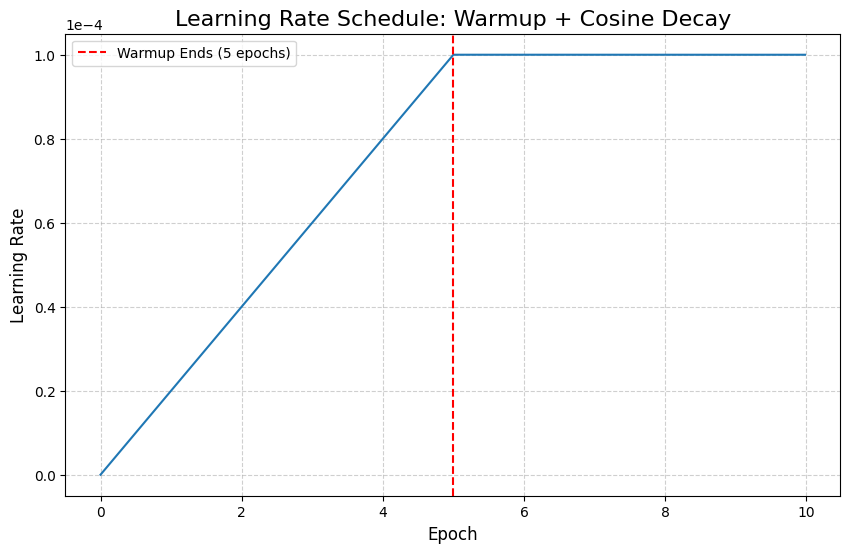

In [13]:
import matplotlib.pyplot as plt
# Let's plot for 100 epochs to see the relevant part of the curve clearly
num_epochs_to_plot = 10
alpha = 0.1

# --- Calculate the steps ---
warmup_steps = warmup_epochs * steps_per_epoch
total_steps_to_plot = num_epochs_to_plot * steps_per_epoch
total_decay_steps = (num_epochs - warmup_epochs) * steps_per_epoch

# --- Generate the learning rate values for each step ---
steps = np.arange(total_steps_to_plot)
learning_rates = np.zeros_like(steps, dtype=float)

# 1. Warmup Phase
# Linearly increases from 0 to peak_lr
warmup_mask = steps < warmup_steps
learning_rates[warmup_mask] = peak_lr * (steps[warmup_mask] / warmup_steps)

# 2. Cosine Decay Phase
decay_mask = steps >= warmup_steps
decay_phase_steps = steps[decay_mask] - warmup_steps

# Cosine decay formula
cosine_decay = 0.5 * (1 + np.cos(np.pi * decay_phase_steps / total_decay_steps))
decay_lr_values = (peak_lr - (peak_lr * alpha)) * cosine_decay + (peak_lr * alpha)
learning_rates[decay_mask] = decay_lr_values

# --- Create the plot ---
# Convert steps to epochs for the x-axis
epochs = steps / steps_per_epoch

plt.figure(figsize=(10, 6))
plt.plot(epochs, learning_rates)
plt.title('Learning Rate Schedule: Warmup + Cosine Decay', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Learning Rate', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Add a vertical line to show where the warmup ends
plt.axvline(x=warmup_epochs, color='r', linestyle='--', label=f'Warmup Ends ({warmup_epochs} epochs)')
plt.legend()

# Format the y-axis for better readability
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.show()

In [14]:
transformer_model.compile(
    optimizer=tf.keras.optimizers.AdamW(
        learning_rate=lr_schedule,
        weight_decay = 2e-3,
        beta_1=0.87,  
        beta_2=0.999,  # Primary recommendation: lower this
        clipnorm=1.0
    ),
    loss='mse'
)

In [15]:


history = transformer_model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs=num_epochs,
    verbose=1, # Suppress output
    callbacks=[early_stopping]
)

Epoch 1/1000


I0000 00:00:1754861609.715879  324196 service.cc:145] XLA service 0xfffe4c0215c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754861609.715944  324196 service.cc:153]   StreamExecutor device (0): Orin, Compute Capability 8.7
2025-08-10 23:33:30.267209: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-10 23:33:32.462848: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 90300
I0000 00:00:1754861623.571616  324428 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_85', 60 bytes spill stores, 60 bytes spill loads

I0000 00:00:1754861624.410764  324431 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_61', 168 bytes spill stores, 144 bytes spill loads

I0000 00:00:1754861626.181911 

 8/60 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 25.8847

I0000 00:00:1754861644.590205  324196 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 25.5989

I0000 00:00:1754861656.728812  324839 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_85', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1754861657.960393  324838 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_85', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1754861658.225759  324842 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6', 468 bytes spill stores, 276 bytes spill loads

I0000 00:00:1754861659.010683  324841 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_89', 24 bytes spill stores, 24 bytes spill loads

I0000 00:00:1754861659.659756  324839 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6', 28 bytes spill stores, 20 bytes spill loads

I0000 00:00:1754861659.924179  324842 asm_

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - loss: 25.5965

I0000 00:00:1754861683.440951  325238 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_19', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1754861684.686855  325241 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1754861685.180177  325242 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6', 468 bytes spill stores, 276 bytes spill loads

I0000 00:00:1754861685.783377  325238 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_19', 32 bytes spill stores, 48 bytes spill loads

I0000 00:00:1754861686.327193  325241 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6', 28 bytes spill stores, 20 bytes spill loads



60/60 ━━━━━━━━━━━━━━━━━━━━ 92s 744ms/step - loss: 25.4560 - val_loss: 26.5463
Epoch 2/1000
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 23.9855 - val_loss: 26.2917
Epoch 3/1000
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 24.4253 - val_loss: 25.4895
Epoch 4/1000
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 23.5938 - val_loss: 24.0279
Epoch 5/1000
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 22.7579 - val_loss: 23.0494
Epoch 6/1000
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 22.4119 - val_loss: 21.7484
Epoch 7/1000
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 21.1557 - val_loss: 20.1901
Epoch 8/1000
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 20.1603 - val_loss: 19.9144
Epoch 9/1000
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 20.2887 - val_loss: 21.6363
Epoch 10/1000
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 19.7788 - val_loss: 20.0788
Epoch 11/1000
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 19.1184 - val_loss: 18.1431
Epoch 12/1000
60/60 ━━━━━━━━━━

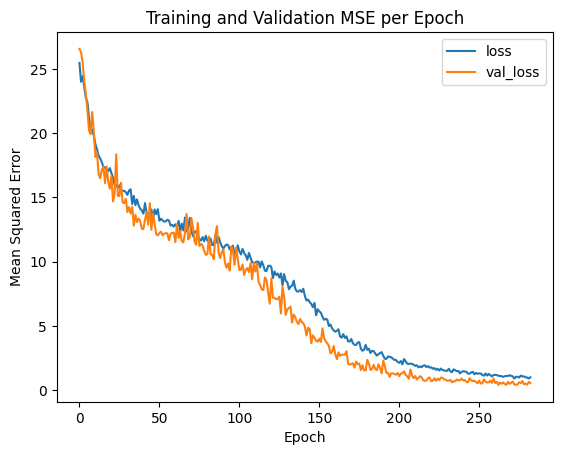

In [16]:

import pandas as pd
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.title("Training and Validation MSE per Epoch")
plt.show()

In [17]:
transformer_model.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16, 128)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Encoder)               │ ?                      │       396,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,190,788 (4.54 MB)

 Trainable params: 396,929 (1.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 793,859 (3.03 MB)

In [18]:
# 1. Take one batch from the dataset to inspect it or use it for prediction.
first_batch = val_dataset.take(1)

# To print the contents of that first batch, you can iterate over it.
# (Note: .take(1) creates a new dataset with only one element, so this loop will run once)
print("Contents of the first batch:")
for batch in first_batch:
    # A batch is typically a tuple of (inputs, labels)
    inputs, labels = batch
    print("Inputs shape:", inputs.shape)
    print("Labels shape:", labels.shape)
print(inputs[0])
# 2. Run prediction on that single batch.
# The model's predict method can directly accept the dataset object created by .take(1).
print("\nRunning prediction on the first batch...")
predictions = transformer_model.predict(first_batch)
print("Predictions shape:", predictions.shape)
print(predictions[0])
print("--------------")
print(predictions)

Contents of the first batch:
Inputs shape: (32, 16)
Labels shape: (32,)
tf.Tensor(
[15.   0.   1.   0.   1.   0.   0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
  0.5  0.5], shape=(16,), dtype=float32)

Running prediction on the first batch...


2025-08-10 23:39:03.696634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predictions shape: (32, 1)
[-0.8673912]
--------------
[[ -0.8673912 ]
 [  0.6076574 ]
 [ -4.7937922 ]
 [  0.24695963]
 [ -5.159548  ]
 [ -2.0020282 ]
 [  3.8815045 ]
 [ -6.5395136 ]
 [-10.422736  ]
 [ -5.9876833 ]
 [  2.2814827 ]
 [ -2.4297163 ]
 [ -3.889476  ]
 [  5.130598  ]
 [  4.7279625 ]
 [ -4.4191027 ]
 [ -2.100268  ]
 [ -2.6383085 ]
 [  2.207272  ]
 [  9.426519  ]
 [ -7.4058332 ]
 [ -2.9149323 ]
 [  2.0934498 ]
 [ -3.8876915 ]
 [ -2.16086   ]
 [ -7.0521755 ]
 [  0.15693204]
 [  2.3739872 ]
 [  6.030548  ]
 [  5.7041564 ]
 [  5.7917523 ]
 [ -1.482544  ]]
